### Demo of stochastic variational heteroscedastic GP (SVHGP) on a 1D toy case

Typically, the HGP model is expressed as

$y(x) = f(x) + \mathcal{N}(0, \sigma^2(x))$,

where $f  \sim \mathcal{GP}(0, k_f(.,.))$ and the log of $\sigma^2(x)$ is

$\log \sigma^2(x) = g(x) \sim \mathcal{GP}(\mu_0, k_g(.,.))$.

To imrpove the scalability of HGP, we introduce $m$ inducing variables $\mathbf{f}_m$ for the latent function variables $\mathbf{f}$, and $u$ inducing variables $\mathbf{g}_u$ for the latent noise variables $\mathbf{g}$. Then, by introducing variational distributions $q(\mathbf{f}_m)$ and $q(\mathbf{g}_u)$, we obtain the following evidence lower bound (ELBO) (see [this paper](https://arxiv.org/abs/1811.01179) for details):

$F = \sum_{i=1}^n \left[ \log \mathcal{N}(y_i|[\mathbf{\mu}_f]_i, [\mathbf{R}_g]_{ii}) - \frac{1}{4}[\mathbf{\Sigma}_g]_{ii} - \frac{1}{2}[\mathbf{\Sigma}_f\mathbf{R}_g^{-1}]_{ii} \right]
- \mathrm{KL}[q(\mathbf{f}_m) || p(\mathbf{f}_m)] - \mathrm{KL}[q(\mathbf{g}_u) || p(\mathbf{g}_u)]$

which supports stochastic variational inference.

In [243]:
import gpflow
from gpflow.models.svhgp import SVHGP
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import copy
import time
from IPython.display import clear_output
# plt.style.use('ggplot')

The 1D toy case is the sinc function plus input-dependent noise

In [272]:
rns = np.random.RandomState(916)
N = 50
X1_state = np.linspace(-2,2,num=N).reshape(-1,1)
X2_state = np.linspace(-2,2,num=N).reshape(-1,1)
X_grid = np.meshgrid(X1_state, X2_state)
X = np.vstack((X_grid[0].reshape(-1), X_grid[1].reshape(-1)))

SX = 0.01+(1/(1+np.exp(-0.2*X_grid[0])))*(1+np.sin(2*X_grid[1]))*0.2
Y_noise = rns.randn(*np.shape(X_grid[0])) * SX
Y_true = np.sinc(np.sqrt(np.sum(np.power(X_grid, 2), axis=0))*2)

Y_grid = Y_true + Y_noise
Ynorm_grid = ((Y_grid - Y_grid.mean()) / Y_grid.std())

X = np.vstack((X_grid[0].reshape(-1), X_grid[1].reshape(-1)))
Y = Y_grid.reshape(-1, 1)
Ynorm = Ynorm_grid.reshape(-1, 1)

print(np.shape(X_grid), np.shape(Y_grid), np.shape(Ynorm_grid))
print(np.shape(X), np.shape(Y), np.shape(Ynorm))

# SX = 0.05+(1/(1+np.exp(-0.2*X)))*(1+np.sin(2*X))*0.2   
# Y = np.sinc(X)+rns.randn(X.shape[0], X.shape[1]) * SX

# # normalize Y to zero mean and unit variance
# Ynorm = (Y - Y.mean()) / Y.std()

(2, 50, 50) (50, 50) (50, 50)
(2, 2500) (2500, 1) (2500, 1)


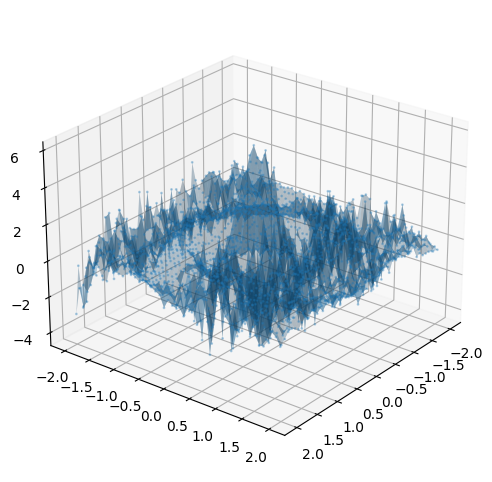

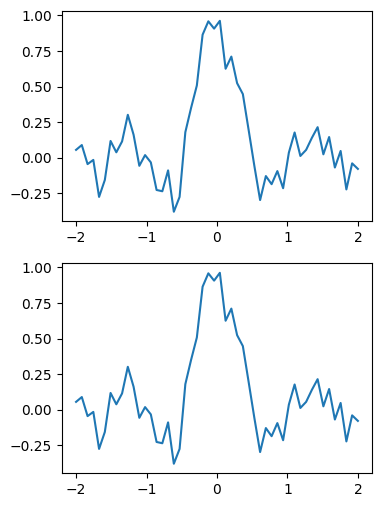

In [273]:
for i in range(10):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X_grid[0], X_grid[1], Ynorm_grid, alpha=0.3)
    ax.scatter(X[0,:], X[1,:], Ynorm, s=1, alpha=0.3)
    ax.view_init(elev=25., azim=2*i+20)
    clear_output(wait=True)
    plt.show()
    

plt.figure(figsize=(4, 6))
plt.subplot(2, 1, 1)
plt.plot(X1_state, Y_grid[N//2, :])
plt.subplot(2, 1, 2)
plt.plot(X2_state, Y_grid[N//2, :])
plt.show()

Construct SVHGP model

In [274]:
minibatch_size = 50
lengthscales = 10
m = SVHGP(X.T, Y,
#           kern=gpflow.kernels.SquaredExponential([1, 1], lengthscales=5, ARD=True),
#           kern_g=gpflow.kernels.SquaredExponential([1, 1], lengthscales=5, ARD=True),
          kern=gpflow.kernels.Matern32(2,lengthscales=lengthscales), 
          kern_g=gpflow.kernels.Matern32(2,lengthscales=lengthscales),
          likelihood=gpflow.likelihoods.HeteroGaussian(),
          Z=X[:,::20].T.copy(), Z_g=X[:,::20].T.copy(), num_latent=1,
          minibatch_size=minibatch_size)

In [275]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVHGP/feature/Z,Parameter,None,(none),True,"(125, 2)",True,"[[-2.0, -2.0], [-0.3673469387755104, -2.0], [1..."
SVHGP/feature_g/Z,Parameter,None,(none),True,"(125, 2)",True,"[[-2.0, -2.0], [-0.3673469387755104, -2.0], [1..."
SVHGP/kern/lengthscales,Parameter,None,+ve,True,(),True,10.0
SVHGP/kern/variance,Parameter,None,+ve,True,(),True,1.0
SVHGP/kern_g/lengthscales,Parameter,None,+ve,True,(),True,10.0
SVHGP/kern_g/variance,Parameter,None,+ve,True,(),True,1.0
SVHGP/mu0_g,Parameter,None,(none),True,(),True,0.0
SVHGP/q_mu,Parameter,None,(none),True,"(125, 1)",True,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
SVHGP/q_mu_g,Parameter,None,(none),True,"(125, 1)",True,"[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...."
SVHGP/q_sqrt,Parameter,None,LoTri->vec,True,"(1, 125, 125)",True,"[[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."


Train SVHGP model

In [282]:
# m.compile()

# natgrad_opt = gpflow.train.NatGradOptimizer(gamma=0.01)
# variational_vars = [(m.q_mu, m.q_sqrt), (m.q_mu_g, m.q_sqrt_g)]

# natgrad_opt.minimize(m, maxiter=2000, var_list=variational_vars)

adam_opt = gpflow.train.AdamOptimizer(0.01)
adam_opt.minimize(m, maxiter=10000)

In [283]:
m.as_pandas_table()

,class,prior,transform,trainable,shape,fixed_shape,value
SVHGP/feature/Z,Parameter,None,(none),True,"(125, 2)",True,"[[-2.168046698930123, -1.55581474115526], [-1...."
SVHGP/feature_g/Z,Parameter,None,(none),True,"(125, 2)",True,"[[-6.576025266736937, -3.8874191469486723], [-..."
SVHGP/kern/lengthscales,Parameter,None,+ve,True,(),True,0.7295562878138928
SVHGP/kern/variance,Parameter,None,+ve,True,(),True,0.017628039993471033
SVHGP/kern_g/lengthscales,Parameter,None,+ve,True,(),True,1.9949003534762446
SVHGP/kern_g/variance,Parameter,None,+ve,True,(),True,4.295699208498433
SVHGP/mu0_g,Parameter,None,(none),True,(),True,-0.03455459363828818
SVHGP/q_mu,Parameter,None,(none),True,"(125, 1)",True,"[[-0.08527323953153985], [0.38719347718034763]..."
SVHGP/q_mu_g,Parameter,None,(none),True,"(125, 1)",True,"[[-0.20107702233361555], [-1.4183028647027558]..."
SVHGP/q_sqrt,Parameter,None,LoTri->vec,True,"(1, 125, 125)",True,"[[[0.3777127892102008, 0.0, 0.0, 0.0, 0.0, 0.0..."


Plot predictions

In [284]:
# predictions
# X_pred = np.hstack((X1_state, X2_state[20]*np.ones_like(X1_state)))
M = 100

Xp1_state = np.linspace(-2,2,num=M).reshape(-1,1)
Xp2_state = np.linspace(-2,2,num=M).reshape(-1,1)
Xp_grid = np.meshgrid(Xp1_state, Xp2_state)
Xp = np.vstack((Xp_grid[0].reshape(-1), Xp_grid[1].reshape(-1)))


Yp, Ypvar = m.predict_y(Xp.T)
Yp_grid = Yp.reshape(M, M)
Ypvar_grid = Ypvar.reshape(M, M)

# denormalize mu and var
# mu = mu * Y.std() + Y.mean()
# var = var * Y.var()

print(np.shape(Xp), np.shape(Yp), np.shape(Yp_grid), np.shape(Ypvar_grid))


# mu_f, var_f = m.predict_f(X)
# # denormalize mu_f and var_g
# mu_f = mu_f * Y.std() + Y.mean()
# var_f = var_f * Y.var()

# # extract inducing points for f and g
# zz = m.feature.Z.read_value()
# zz_g = m.feature_g.Z.read_value()

(2, 10000) (10000, 1) (100, 100) (100, 100)


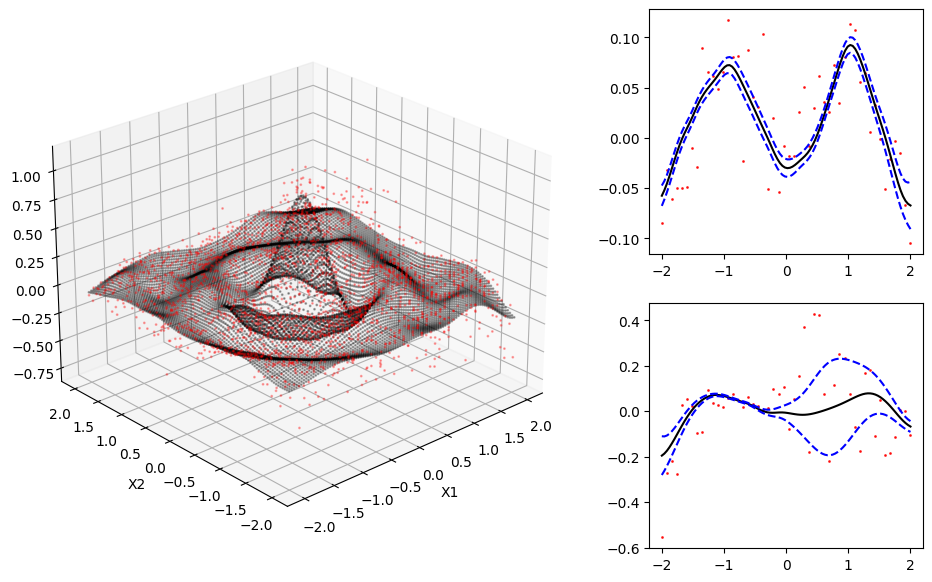

IndexError: index 50 is out of bounds for axis 0 with size 50

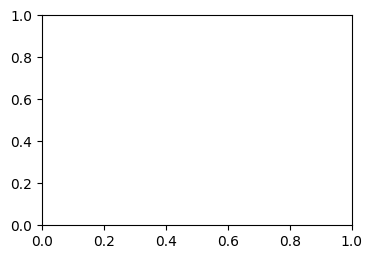

In [285]:
for i in range(N):
    fig = plt.figure(figsize=(12, 7))

    ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=2, rowspan=2, projection='3d')
#     ax.plot_surface(X_grid[0], X_grid[1], mu.reshape(np.shape(X_grid[0])), alpha=0.3)
    
    ax1.scatter(X[0,:], X[1,:], Y, s=1, alpha=0.3, color='r')
    ax1.scatter(Xp[0,:], Xp[1,:], Yp, s=1, alpha=0.3, color='k')
    ax1.view_init(elev=25., azim=2*i+30)
    ax1.set_xlabel('X1')
    ax1.set_ylabel('X2')
    
    ax2 = plt.subplot2grid((2, 3), (0, 2))
    ax2.scatter(X1_state, Y_grid[i//2, :], c='r', s=1, alpha=0.8)
    ax2.plot(Xp1_state, Yp_grid[i, :], 'k')
    ax2.plot(Xp1_state, Yp_grid[i, :]+2*Ypvar_grid[i, :], '--b')
    ax2.plot(Xp1_state, Yp_grid[i, :]-2*Ypvar_grid[i, :], '--b')
    
    ax3 = plt.subplot2grid((2, 3), (1, 2))
    ax3.scatter(X2_state, Y_grid[:, i//2], c='r', s=1, alpha=0.8)
    ax3.plot(Xp2_state, Yp_grid[:, i], 'k')
    ax3.plot(Xp2_state, Yp_grid[:, i]+2*Ypvar_grid[:, i], '--b')
    ax3.plot(Xp2_state, Yp_grid[:, i]-2*Ypvar_grid[:, i], '--b')
    
    clear_output(wait=True)
    plt.show()
    time.sleep(0.1)

In the fig, the top circles are locations of optimized inducing points for latent function f; the bottom circles are locations of optimized inducing points for latent log noise function g; the black dash curves represent the prediction confidence of f; the red dash curves represent the final prediction confidence.